In [1]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import netCDF4
import cftime
import seaborn
import cmocean
import matplotlib.gridspec
import scipy.interpolate

import glob
import pandas

import mpl_toolkits
import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

# 30day runs

import cam 400 data

In [2]:
cont_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm0400.ens_10members/ens_mean_cesm_files/'
cont_filename = 'B_1850_CAM5.30days.cam0400.clm0400.ens.cam.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
cont_cam_ds = xarray.open_dataset(cont_fileroot+cont_filename, decode_times=False)

In [3]:
topo_filename = 'USGS-gtopo30_1.9x2.5_remap_c050602.nc'
topo_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm0400.ens_10members/'
topo_ds = xarray.open_dataset(topo_fileroot+topo_filename, decode_times=False)

calculate latitude information

In [4]:
lat_lo = -10.
lat_hi = 10.
lon_lo = 270.
lon_hi = 330.

In [5]:
lat = cont_cam_ds['lat'].values
lon = cont_cam_ds['lon'].values

lat_indices = (lat>=lat_lo)&(lat<=lat_hi)
lon_indices = (lon>=lon_lo)&(lon<=lon_hi)

lat_subset = lat[lat_indices]
lon_subset = lon[lon_indices]

get land fraction info

In [7]:
LANDFRAC = cont_cam_ds['LANDFRAC'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values[0,:,:]

get 400 fields for cam

In [8]:
PRECC_400_30d = cont_cam_ds['PRECC'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values
PRECL_400_30d = cont_cam_ds['PRECL'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values

import cam 1000 data

In [9]:
phys_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm1000.ens_10members/ens_mean_cesm_files/'
phys_filename = 'B_1850_CAM5.30days.cam0400.clm1000.ens.cam.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
phys_cam_ds = xarray.open_dataset(phys_fileroot+phys_filename, decode_times=False)

get 1000 fields for cam

In [10]:
PRECC_1000_30d = phys_cam_ds['PRECC'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values
PRECL_1000_30d = phys_cam_ds['PRECL'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values

convert time information

In [11]:
time_400 = cont_cam_ds['time']
time_converted = netCDF4.num2date(time_400.values, time_400.units, time_400.calendar)

time_manual = []
for t_idx in range(time_converted.size):
    year=time_converted[t_idx].year
    month=time_converted[t_idx].month
    day=time_converted[t_idx].day
    hour=time_converted[t_idx].hour
    minute=time_converted[t_idx].minute
    hour_round = round(hour+minute/60)
    time_manual.append(cftime.DatetimeNoLeap(year,month,day,hour_round))

specify timing

In [12]:
skip_time = 24
#end_time = 745

calculate PRECT diffs

In [13]:
PRECT_400_30d = PRECC_400_30d+PRECL_400_30d
PRECT_1000_30d = PRECC_1000_30d+PRECL_1000_30d

In [14]:
PRECT_1000_timemean_10day = numpy.mean(PRECT_1000_30d[skip_time:240,:,:], axis=0)
PRECT_1000_timemean_10day_landmask = numpy.copy(PRECT_1000_timemean_10day)
PRECT_1000_timemean_10day_landmask[LANDFRAC==0] = numpy.nan

PRECT_400_timemean_10day = numpy.nanmean(PRECT_400_30d[skip_time:240,:,:], axis=0)
PRECT_400_timemean_10day_landmask = numpy.copy(PRECT_400_timemean_10day)
PRECT_400_timemean_10day_landmask[LANDFRAC==0] = numpy.nan

In [15]:
PRECT_1000_timemean_30day = numpy.mean(PRECT_1000_30d[skip_time:,:,:], axis=0)
PRECT_1000_timemean_30day_landmask = numpy.copy(PRECT_1000_timemean_30day)
PRECT_1000_timemean_30day_landmask[LANDFRAC==0] = numpy.nan

PRECT_400_timemean_30day = numpy.nanmean(PRECT_400_30d[skip_time:,:,:], axis=0)
PRECT_400_timemean_30day_landmask = numpy.copy(PRECT_400_timemean_30day)
PRECT_400_timemean_30day_landmask[LANDFRAC==0] = numpy.nan

get topography info

In [16]:
topo_data = topo_ds['PHIS'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values/9.80665

In [17]:
topo_data_landmask = numpy.copy(topo_data)
topo_data_landmask[LANDFRAC==0] = numpy.nan
topo_data_latmean = numpy.nanmean(topo_data_landmask, axis=0)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# 10year simulations

400 clm runs

In [18]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm0400/'
cont_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc', decode_times=False)

In [19]:
PRECC_400_10y = cont_cam_mfds['PRECC'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values
PRECL_400_10y = cont_cam_mfds['PRECL'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values
PRECT_400_10y = PRECC_400_10y+PRECL_400_10y

1000 clm runs

In [20]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm1000/'
phys_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc')#, decode_times=False)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


In [21]:
PRECC_1000_10y = phys_cam_mfds['PRECC'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values
PRECL_1000_10y = phys_cam_mfds['PRECL'].sel(lat=slice(lat_lo,lat_hi),lon=slice(lon_lo,lon_hi)).values
PRECT_1000_10y = PRECC_1000_10y+PRECL_1000_10y

take time averages

In [22]:
PRECT_400_timemean_10year = numpy.mean(PRECT_400_10y, axis=0)
PRECT_1000_timemean_10year = numpy.mean(PRECT_1000_10y, axis=0)

In [23]:
PRECT_400_timemean_10year_landmask = numpy.copy(PRECT_400_timemean_10year)
PRECT_1000_timemean_10year_landmask = numpy.copy(PRECT_1000_timemean_10year)

PRECT_400_timemean_10year_landmask[LANDFRAC==0] = numpy.nan
PRECT_1000_timemean_10year_landmask[LANDFRAC==0] = numpy.nan

# calculate all differences

In [24]:
PRECT_diffs_10day = PRECT_1000_timemean_10day_landmask-PRECT_400_timemean_10day_landmask
PRECT_diffs_30day = PRECT_1000_timemean_30day_landmask-PRECT_400_timemean_30day_landmask
PRECT_diffs_10year = PRECT_1000_timemean_10year_landmask-PRECT_400_timemean_10year_landmask

# wrf 50km runs

## 400 data

In [25]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [26]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [27]:
rainc_400 = cont_mfds['RAINC'].values
rainnc_400 = cont_mfds['RAINNC'].values

In [28]:
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [29]:
xlat_indices = (xlat>=-10)&(xlat<=10.)

In [30]:
hgt_50km = cont_mfds['HGT'].sel(Time=0).values

In [31]:
hgt_50km_landmask = numpy.copy(hgt_50km)
hgt_50km_landmask[landmask==0] = numpy.nan

hgt_50km_landmask_lat_subset = hgt_50km_landmask[xlat_indices,:]
hgt_50km_latmean = numpy.nanmean(hgt_50km_landmask_lat_subset, axis=0)

IndexError: too many indices for array

## 1000 data

In [ ]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [ ]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [ ]:
rainc_1000 = phys_mfds['RAINC'].values
rainnc_1000 = phys_mfds['RAINNC'].values

## calculate WRF differences

In [ ]:
raintot_400 = rainc_400+rainnc_400
raintot_1000 = rainc_1000+rainnc_1000

raintot_400_diff = numpy.zeros((raintot_400.shape))*numpy.nan
raintot_400_diff[:-1,:,:] = numpy.diff(raintot_400, axis=0)#*(24./3) # convert to mm/day

raintot_1000_diff = numpy.zeros((raintot_1000.shape))*numpy.nan
raintot_1000_diff[:-1,:,:] = numpy.diff(raintot_1000, axis=0)#*(24./3) # convert to mm/day

# monthly mean
raintot_diffs_time_mean = numpy.nanmean(raintot_1000_diff[skip_time:,:,:] - raintot_400_diff[skip_time:,:,:], axis=0)
raintot_diffs_time_mean_landmask = numpy.copy(raintot_diffs_time_mean)
raintot_diffs_time_mean_landmask[landmask==0] = numpy.nan

raintot_400_time_mean = numpy.nanmean(raintot_400_diff[skip_time:,:,:], axis=0)
raintot_400_time_mean_landmask = numpy.copy(raintot_400_time_mean)
raintot_400_time_mean_landmask[landmask==0] = numpy.nan


# import WRF 2km days 2-10

In [ ]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/400/001/'
cont_mfds_2km = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [ ]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/1000/001/'
phys_mfds_2km = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [ ]:
raintot_400_2km = cont_mfds_2km['RAINNC']
raintot_1000_2km = phys_mfds_2km['RAINNC']

In [ ]:
raintot_400_2km_diffs = raintot_400_2km.diff(dim='Time').values
raintot_1000_2km_diffs = raintot_1000_2km.diff(dim='Time').values

In [ ]:
raintot_400_2km_time_mean = numpy.nanmean(raintot_400_2km_diffs[skip_time:,:,:], axis=0)
raintot_1000_2km_time_mean = numpy.nanmean(raintot_1000_2km_diffs[skip_time:,:,:], axis=0)

raintot_diffs_2km_time_mean = raintot_1000_2km_time_mean-raintot_400_2km_time_mean

In [ ]:
landmask_2km = cont_mfds_2km['LANDMASK'].values[0,:,:]

In [ ]:
raintot_diffs_2km_time_mean_landmask = numpy.copy(raintot_diffs_2km_time_mean)
raintot_diffs_2km_time_mean_landmask[landmask_2km==0] = numpy.nan

In [ ]:
xlat_2km = cont_mfds_2km['XLAT'].values[0,:,:]
xlong_2km = cont_mfds_2km['XLONG'].values[0,:,:]

In [ ]:
hgt_2km = cont_mfds_2km['HGT'].sel(Time=0).values

In [ ]:
hgt_2km_landmask = numpy.copy(hgt_2km)
hgt_2km_landmask[landmask_2km==0] = numpy.nan
hgt_2km_latmean = numpy.nanmean(hgt_2km_landmask, axis=0)

# import WRF 2km day 1

# create plots

# calculate lat means

In [ ]:
raintot_diffs_2km_latmean = numpy.nanmean(raintot_diffs_2km_time_mean, axis=0)

In [ ]:
raintot_diffs_time_mean_landmask.shape

In [ ]:
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_time_mean_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0)
raintot_diffs_2km_latmean = numpy.nanmean(raintot_diffs_2km_time_mean, axis=0)
PRECT_diffs_10day_latmean = numpy.nanmean(PRECT_diffs_10day[(lat_subset>=-10)&(lat_subset<=10),:], axis=0)
PRECT_diffs_30day_latmean = numpy.nanmean(PRECT_diffs_30day[(lat_subset>=-10)&(lat_subset<=10),:], axis=0)
PRECT_diffs_10year_latmean = numpy.nanmean(PRECT_diffs_10year[(lat_subset>=-10)&(lat_subset<=10),:], axis=0)

In [ ]:
raintot_diffs_latstd = numpy.nanstd(raintot_diffs_time_mean_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0, ddof=1)
raintot_diffs_2km_latstd = numpy.nanstd(raintot_diffs_2km_time_mean, axis=0, ddof=1)
PRECT_diffs_10day_latstd = numpy.nanstd(PRECT_diffs_10day[(lat_subset>=-10)&(lat_subset<=10),:], axis=0, ddof=1)
PRECT_diffs_30day_latstd = numpy.nanstd(PRECT_diffs_30day[(lat_subset>=-10)&(lat_subset<=10),:], axis=0, ddof=1)
PRECT_diffs_10year_latstd = numpy.nanstd(PRECT_diffs_10year[(lat_subset>=-10)&(lat_subset<=10),:], axis=0, ddof=1)



In [ ]:
raintot_diffs_latstderr = raintot_diffs_latstd/numpy.sqrt(xlat[:,0].size)
raintot_diffs_2km_latstderr = raintot_diffs_2km_latstd/numpy.sqrt(xlat_2km[:,0].size)
PRECT_diffs_10day_latstderr = PRECT_diffs_10day_latstd/numpy.sqrt(lat_subset.size)
PRECT_diffs_30day_latstderr = PRECT_diffs_30day_latstd/numpy.sqrt(lat_subset.size)
PRECT_diffs_10year_latstderr = PRECT_diffs_10year_latstd/numpy.sqrt(lat_subset.size)



In [ ]:
raintot_diffs_latmean_smooth = pandas.Series(raintot_diffs_latmean).rolling(window=3, center=True, min_periods=0).mean()
raintot_diffs_2km_latmean_smooth = pandas.Series(raintot_diffs_2km_latmean).rolling(window=75, center=True, min_periods=0).mean()
PRECT_diffs_10day_latmean_smooth = pandas.Series(PRECT_diffs_10day_latmean).rolling(window=3, center=True, min_periods=0).mean()



In [ ]:
raintot_diffs_latstd_smooth = pandas.Series(raintot_diffs_latstd).rolling(window=3, center=True, min_periods=0).std(ddof=1)
raintot_diffs_2km_latstd_smooth = pandas.Series(raintot_diffs_2km_latstd).rolling(window=75, center=True, min_periods=0).std(ddof=1)



In [ ]:
colors = [cmocean.cm.thermal(0.3),\
          cmocean.cm.thermal(0.4),\
          cmocean.cm.thermal(0.5),\
          cmocean.cm.thermal(0.6),\
          cmocean.cm.thermal(0.7)]

fontsize = 12

fig = mp.figure(figsize=(4.25,5.5))

ymax = 1920.6472595214843
#ax2topo.get_ylim()
##################################################
# xvals = xlong[0,:]+360.
# yvals = raintot_diffs_latmean_smooth*24.
# f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
# xvals_interp = numpy.linspace(277.5, xvals.max(), 1000)
# yvals_interp = f(xvals_interp)
ax1 = fig.add_subplot(511)
ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth*24., \
         color=colors[0],\
         label='WRF 50-km 10d')

ax1topo = ax1.twinx()
ax1topo.fill_between(xlong[0,:]+360., \
                     numpy.zeros(hgt_50km_latmean.size), \
                     hgt_50km_latmean, \
                     facecolor='0', alpha=0.25)
y0,y1 = ax1topo.get_ylim()
ax1topo.set_ylim(0,ymax)
ax1topo.axis('off')

# ax1.fill_between(xlong[0,:]+360., \
#                 (raintot_diffs_latmean_smooth-raintot_diffs_latstd_smooth)*24.,\
#                 (raintot_diffs_latmean_smooth+raintot_diffs_latstd_smooth)*24.,\
#                 facecolor=colors[0], alpha=0.333)


##################################################
xvals = xlong_2km[0,:]+360.
yvals = raintot_diffs_2km_latmean_smooth*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
xvals_interp = numpy.linspace(xvals.min(), xvals.max(), 1000)
yvals_interp = f(xvals_interp)
ax2 = fig.add_subplot(512)
ax2.plot(xvals_interp,\
        yvals_interp, \
        color=colors[1],\
        label='WRF 2-km 10d')

ax2topo = ax2.twinx()
ax2topo.fill_between(xlong_2km[0,:]+360., \
                     numpy.zeros(hgt_2km_latmean.size), \
                     hgt_2km_latmean, \
                     facecolor='0', alpha=0.25)
ax2topo.set_ylim(0,ymax)
ax2topo.axis('off')

# yvals = PRECT_diffs_10day_latstderr
# yvals_interp_error = f(xvals_interp)
# f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
# ax2.fill_between(xlong_2km[0,:]+360., \
#                 (raintot_diffs_2km_latmean_smooth-raintot_diffs_2km_latstd_smooth)*24.,\
#                 (raintot_diffs_2km_latmean_smooth+raintot_diffs_2km_latstd_smooth)*24.,\
#                 facecolor=colors[1], alpha=0.333)

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10day_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax3 = fig.add_subplot(513)
ax3.plot(xvals_interp,\
        yvals_interp*86400.*1000., \
        color=colors[2],\
        label='CESM 2$\degree$ 10d')

ax3topo = ax3.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax3topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax3topo.set_ylim(0,ymax)
ax3topo.axis('off')

# ax3topo.fill_between(lon_subset, \
#                      numpy.zeros(topo_data_latmean.size), \
#                      topo_data_latmean, \
#                      facecolor='0', alpha=0.25)

# yvals = PRECT_diffs_10day_latstderr
# f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
# yvals_interp_error = f(xvals_interp)
# ax3.fill_between(xvals_interp, \
#                 (yvals_interp+yvals_interp_error)*86400.*1000.,\
#                 (yvals_interp-yvals_interp_error)*86400.*1000.,\
#                 facecolor=colors[1], alpha=0.333)


##################################################
xvals = lon_subset
yvals = PRECT_diffs_30day_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax4 = fig.add_subplot(514)
ax4.plot(xvals_interp,\
        yvals_interp*86400.*1000., \
        color=colors[3],\
        label='CESM 2$\degree$ 30d')

ax4topo = ax4.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax4topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax4topo.set_ylim(0,ymax)
ax4topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10year_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax5 = fig.add_subplot(515)
ax5.plot(xvals_interp,\
       yvals_interp*86400.*1000., \
       color=colors[4],\
       label='CESM 2$\degree$ 10yr')

ax5topo = ax5.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax5topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax5topo.set_ylim(0,ymax)
ax5topo.axis('off')

##################################################

ax_list = [ax1,ax2,ax3,ax4,ax5]
label_list = ['(a) WRF 50-km 10d',\
              '(b) WRF 2-km 10d', \
              '(c) CESM 2$\degree$ 10d', \
              '(d) CESM 2$\degree$ 30d', \
              '(e) CESM 2$\degree$ 10y']

fig.tight_layout()#h_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

map_lat_lo = -10.
map_lat_hi = 10.
map_lon_lo = 278
map_lon_hi = 325.5

ax1.zorder=1
ax2.zorder=1
ax3.zorder=1
ax4.zorder=1
ax5.zorder=1

ax1.set_facecolor('None')
ax2.set_facecolor('None')
ax3.set_facecolor('None')
ax4.set_facecolor('None')
ax5.set_facecolor('None')

[ax.tick_params(labelsize=fontsize) for ax in ax_list]
[ax.set_xticklabels(['','','']) for ax in ax_list]
[ax.axhline(0, lw=1, ls='--', c='0.1') for ax in ax_list]
#[ax.set_ylim(-1.8,1.8) for ax in ax_list]
[ax.set_yticks([-1.,0,1.]) for ax in ax_list]
[ax_list[i].yaxis.tick_right() for i in [1,3]]
[ax.set_xlim(map_lon_lo, map_lon_hi) for ax in ax_list]
[ax.xaxis.grid() for ax in ax_list]
[ax.set_xticks([280,290,300.,310,320.]) for ax in ax_list]

[ax_list[i].text(s=label_list[i], x=0.98, y=0.87,\
                 ha='right', va='top', \
                 fontsize=fontsize, \
                 color=colors[i], \
                 transform=ax_list[i].transAxes) for i in range(5)]

ax1pos = ax1.get_position()
ax4pos = ax4.get_position()
ax5pos = ax5.get_position()
fig.text(s='mm day$^{\,-1}$', \
         x=0, y=ax5pos.y0+0.5*(ax1pos.y1-ax5pos.y0), \
         rotation=90, \
         transform=fig.transFigure, \
         va='center', \
         ha='right', \
         fontsize=fontsize)

ax5.set_xlabel('longitude', fontsize=fontsize)
ax5.set_xticklabels(['280$\degree$E','','300$\degree$E','','320$\degree$E'])

# ax_orog = fig.add_axes([ax1pos.x0,ax1pos.y1,ax1pos.width,ax1pos.height])
# ax_orog.axis('off')
# ax_orog.plot(xlong[0,:]+360., HGT_M_lat_subset_mean, \
#              ls='--', \
#              c=cmocean.cm.thermal(0.2))
# ax_orog.set_xlim(ax1.get_xlim())

# width_to_height = (map_lon_hi-map_lon_lo)/(map_lat_hi-map_lat_lo)
# map_height = ax5pos.width/width_to_height

# ax_map = fig.add_axes([ax5pos.x0, 0.5*((ax1pos.y1-ax5pos.y0)-map_height), ax5pos.width, map_height], projection=map_proj)
# ax_map.set_extent([map_lon_lo,map_lon_hi,map_lat_lo,map_lat_hi], crs=map_proj)
# ax_map.background_patch.set_facecolor('None')
# ax_map.zorder=0
# ax_map.outline_patch.set_visible(False)
# ax_map.add_feature(cartopy.feature.LAND, \
#                    facecolor='0', \
#                    edgecolor='None', \
#                    alpha=0.2)

fig.savefig('figures/manuscript_fig4_precip_change_latmean_plots.png', dpi=600, bbox_inches='tight', transparent=True)


In [ ]:
hgt_2km_latmean.max()

In [ ]:
colors = [cmocean.cm.thermal(0.3),\
          cmocean.cm.thermal(0.4),\
          cmocean.cm.thermal(0.5),\
          cmocean.cm.thermal(0.6),\
          cmocean.cm.thermal(0.7)]

fontsize = 18

fig = mp.figure(figsize=(3.5,5.5))

##################################################
# xvals = xlong[0,:]+360.
# yvals = raintot_diffs_latmean_smooth*24.
# f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
# xvals_interp = numpy.linspace(277.5, xvals.max(), 1000)
# yvals_interp = f(xvals_interp)
ax1 = fig.add_subplot(511)
ax1.plot(xlong[0,:]+360.,\
        raintot_diffs_latmean_smooth*24., \
        color=colors[0],\
        label='WRF 50-km 10d')
# ax1.fill_between(xlong[0,:]+360., \
#                 (raintot_diffs_latmean_smooth-raintot_diffs_latstd_smooth)*24.,\
#                 (raintot_diffs_latmean_smooth+raintot_diffs_latstd_smooth)*24.,\
#                 facecolor=colors[0], alpha=0.333)


##################################################
xvals = xlong_2km[0,:]+360.
yvals = raintot_diffs_2km_latmean_smooth*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
xvals_interp = numpy.linspace(xvals.min(), xvals.max(), 1000)
yvals_interp = f(xvals_interp)
ax2 = fig.add_subplot(512)
ax2.plot(xvals_interp,\
        yvals_interp, \
        color=colors[1],\
        label='WRF 2-km 10d')
# yvals = PRECT_diffs_10day_latstderr
# yvals_interp_error = f(xvals_interp)
# f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
# ax2.fill_between(xlong_2km[0,:]+360., \
#                 (raintot_diffs_2km_latmean_smooth-raintot_diffs_2km_latstd_smooth)*24.,\
#                 (raintot_diffs_2km_latmean_smooth+raintot_diffs_2km_latstd_smooth)*24.,\
#                 facecolor=colors[1], alpha=0.333)

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10day_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax3 = fig.add_subplot(513)
ax3.plot(xvals_interp,\
        yvals_interp*86400.*1000., \
        color=colors[2],\
        label='CESM 2$\degree$ 10d')
# yvals = PRECT_diffs_10day_latstderr
# f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
# yvals_interp_error = f(xvals_interp)
# ax3.fill_between(xvals_interp, \
#                 (yvals_interp+yvals_interp_error)*86400.*1000.,\
#                 (yvals_interp-yvals_interp_error)*86400.*1000.,\
#                 facecolor=colors[1], alpha=0.333)


##################################################
xvals = lon_subset
yvals = PRECT_diffs_30day_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax4 = fig.add_subplot(514)
ax4.plot(xvals_interp,\
        yvals_interp*86400.*1000., \
        color=colors[3],\
        label='CESM 2$\degree$ 30d')


##################################################
xvals = lon_subset
yvals = PRECT_diffs_10year_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax5 = fig.add_subplot(515)
ax5.plot(xvals_interp,\
       yvals_interp*86400.*1000., \
       color=colors[4],\
       label='CESM 2$\degree$ 10yr')

##################################################

ax_list = [ax1,ax2,ax3,ax4,ax5]
label_list = ['WRF 50-km 10d',\
              'WRF 2-km 10d', \
              'CESM 2$\degree$ 10d', \
              'CESM 2$\degree$ 30d', \
              'CESM 2$\degree$ 10y']

fig.tight_layout()#h_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

map_lat_lo = -10.
map_lat_hi = 10.
map_lon_lo = 278
map_lon_hi = 325.5

ax1.zorder=1
ax2.zorder=1
ax3.zorder=1
ax4.zorder=1
ax5.zorder=1

ax1.set_facecolor('None')
ax2.set_facecolor('None')
ax3.set_facecolor('None')
ax4.set_facecolor('None')
ax5.set_facecolor('None')

[ax.tick_params(labelsize=fontsize) for ax in ax_list]
[ax.set_xticklabels(['','','']) for ax in ax_list]
[ax.axhline(0, lw=1, ls='--', c='0.1') for ax in ax_list]
#[ax.set_ylim(-1.8,1.8) for ax in ax_list]
[ax.set_yticks([-1.,0,1.]) for ax in ax_list]
[ax_list[i].yaxis.tick_right() for i in [1,3]]
[ax.set_xlim(map_lon_lo, map_lon_hi) for ax in ax_list]
[ax.xaxis.grid() for ax in ax_list]
[ax.set_xticks([280,290,300.,310,320.]) for ax in ax_list]

[ax_list[i].text(s=label_list[i], x=0.98, y=0.87,\
                 ha='right', va='top', \
                 fontsize=fontsize, \
                 color=colors[i], \
                 transform=ax_list[i].transAxes) for i in range(5)]

ax1pos = ax1.get_position()
ax4pos = ax4.get_position()
ax5pos = ax5.get_position()
fig.text(s='mm day$^{\,-1}$', \
         x=0, y=ax5pos.y0+0.5*(ax1pos.y1-ax5pos.y0), \
         rotation=90, \
         transform=fig.transFigure, \
         va='center', \
         ha='right', \
         fontsize=fontsize)

ax5.set_xlabel('longitude', fontsize=fontsize)
ax5.set_xticklabels(['280$\degree$E','','300$\degree$E','','320$\degree$E'])

ax_orog = fig.add_axes([ax1pos.x0,ax1pos.y1,ax1pos.width,ax1pos.height])
ax_orog.axis('off')
ax_orog.plot(xlong[0,:]+360., HGT_M_lat_subset_mean, \
             ls='--', \
             c=cmocean.cm.thermal(0.2))
ax_orog.set_xlim(ax1.get_xlim())

# width_to_height = (map_lon_hi-map_lon_lo)/(map_lat_hi-map_lat_lo)
# map_height = ax5pos.width/width_to_height

# ax_map = fig.add_axes([ax5pos.x0, 0.5*((ax1pos.y1-ax5pos.y0)-map_height), ax5pos.width, map_height], projection=map_proj)
# ax_map.set_extent([map_lon_lo,map_lon_hi,map_lat_lo,map_lat_hi], crs=map_proj)
# ax_map.background_patch.set_facecolor('None')
# ax_map.zorder=0
# ax_map.outline_patch.set_visible(False)
# ax_map.add_feature(cartopy.feature.LAND, \
#                    facecolor='0', \
#                    edgecolor='None', \
#                    alpha=0.2)

fig.savefig('figures/cesm_workshop_latmean_plots.png', dpi=600, bbox_inches='tight', transparent=True)


In [50]:
ax_list_for_ylim = numpy.copy(ax_list)

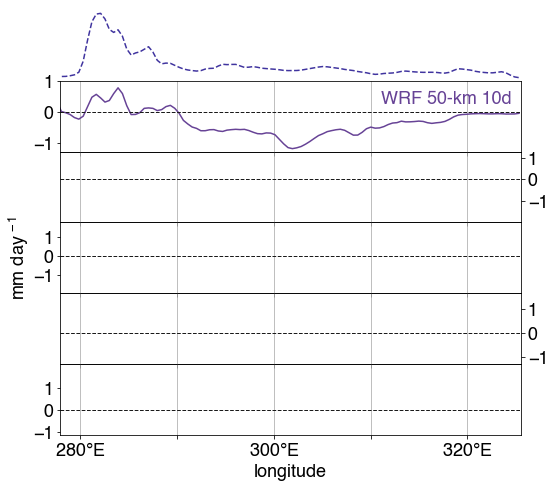

In [51]:
num = 1

colors = [cmocean.cm.thermal(0.3),\
          cmocean.cm.thermal(0.4),\
          cmocean.cm.thermal(0.5),\
          cmocean.cm.thermal(0.6),\
          cmocean.cm.thermal(0.7)]

fontsize = 18
fig = mp.figure(figsize=(7,5.5))

##################################################
ax1 = fig.add_subplot(511)
ax1.plot(xlong[0,:]+360.,\
        raintot_diffs_latmean_smooth*24., \
        color=colors[0],\
        label='WRF 50-km 10d')

##################################################
xvals = xlong_2km[0,:]+360.
yvals = raintot_diffs_2km_latmean_smooth*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
xvals_interp = numpy.linspace(xvals.min(), xvals.max(), 1000)
yvals_interp = f(xvals_interp)
ax2 = fig.add_subplot(512)
# ax2.plot(xvals_interp,\
#         yvals_interp, \
#         color=colors[1],\
#         label='WRF 2-km 10d')
ax2.plot(xvals_interp,\
        yvals_interp, \
        color='None')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10day_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax3 = fig.add_subplot(513)
# ax3.plot(xvals_interp,\
#         yvals_interp*86400.*1000., \
#         color=colors[2],\
#         label='CESM 2$\degree$ 10d')
ax3.plot(xvals_interp,\
        yvals_interp*86400.*1000., \
        color='None')

# #################################################
xvals = lon_subset
yvals = PRECT_diffs_30day_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax4 = fig.add_subplot(514)
# ax4.plot(xvals_interp,\
#         yvals_interp*86400.*1000., \
#         color=colors[3],\
#         label='CESM 2$\degree$ 30d')
ax4.plot(xvals_interp,\
        yvals_interp*86400.*1000., \
        color='None')

# #################################################
xvals = lon_subset
yvals = PRECT_diffs_10year_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax5 = fig.add_subplot(515)
# ax5.plot(xvals_interp,\
#        yvals_interp*86400.*1000., \
#        color=colors[4],\
#        label='CESM 2$\degree$ 10yr')
ax5.plot(xvals_interp,\
       yvals_interp*86400.*1000., \
       color='None')

##################################################

ax_list = [ax1,ax2,ax3,ax4,ax5]
label_list = ['WRF 50-km 10d',\
              'WRF 2-km 10d', \
              'CESM 2$\degree$ 10d', \
              'CESM 2$\degree$ 30d', \
              'CESM 2$\degree$ 10y']

fig.tight_layout()#h_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

map_lat_lo = -10.
map_lat_hi = 10.
map_lon_lo = 278
map_lon_hi = 325.5

ax1.zorder=1
ax2.zorder=1
ax3.zorder=1
ax4.zorder=1
ax5.zorder=1

ax1.set_facecolor('None')
ax2.set_facecolor('None')
ax3.set_facecolor('None')
ax4.set_facecolor('None')
ax5.set_facecolor('None')

[ax.tick_params(labelsize=fontsize) for ax in ax_list]
[ax.set_xticklabels(['','','']) for ax in ax_list]
[ax.axhline(0, lw=1, ls='--', c='0.1') for ax in ax_list]
[ax.set_yticks([-1.,0,1.]) for ax in ax_list]
[ax_list[i].yaxis.tick_right() for i in [1,3]]
[ax.set_xlim(map_lon_lo, map_lon_hi) for ax in ax_list]
[ax.xaxis.grid() for ax in ax_list]
[ax.set_xticks([280,290,300.,310,320.]) for ax in ax_list]
[ax_list[i].set_ylim(ax_list_for_ylim[i].get_ylim()) \
 for i in range(ax_list.__len__())]

[ax_list[i].text(s=label_list[i], x=0.98, y=0.87,\
                 ha='right', va='top', \
                 fontsize=fontsize, \
                 color=colors[i], \
                 transform=ax_list[i].transAxes) for i in range(num)]

ax1pos = ax1.get_position()
ax4pos = ax4.get_position()
ax5pos = ax5.get_position()
fig.text(s='mm day$^{\,-1}$', \
         x=0, y=ax5pos.y0+0.5*(ax1pos.y1-ax5pos.y0), \
         rotation=90, \
         transform=fig.transFigure, \
         va='center', \
         ha='right', \
         fontsize=fontsize)

ax5.set_xlabel('longitude', fontsize=fontsize)
ax5.set_xticklabels(['280$\degree$E','','300$\degree$E','','320$\degree$E'])

ax_orog = fig.add_axes([ax1pos.x0,\
                        ax1pos.y1,\
                        ax1pos.width,\
                        ax1pos.height])
ax_orog.axis('off')
ax_orog.plot(xlong[0,:]+360., HGT_M_lat_subset_mean, \
             ls='--', \
             c=cmocean.cm.thermal(0.2))
ax_orog.set_xlim(ax1.get_xlim())

fig.savefig('figures/cesm_workshop_latmean_plots_'+str(num)+'.png', \
            dpi=600, bbox_inches='tight', transparent=True)


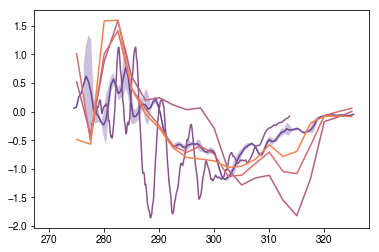

In [52]:
fontsize = 18

fig = mp.figure()

ax = fig.add_subplot(111)

ax.plot(xlong[0,:]+360.,\
        raintot_diffs_latmean_smooth*24., \
        color=colors[0],\
        label='WRF 50-km 10d')
ax.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth-raintot_diffs_latstd_smooth)*24.,\
                (raintot_diffs_latmean_smooth+raintot_diffs_latstd_smooth)*24.,\
                facecolor=colors[0], alpha=0.333)


ax.plot(xlong_2km[0,:]+360.,\
        raintot_diffs_2km_latmean_smooth*24., \
        color=colors[1],\
        label='WRF 2-km 10d')


ax.plot(lon_subset,\
        PRECT_diffs_10day_latmean*86400.*1000., \
        color=colors[2],\
        label='CESM 2$\degree$ 10d')


ax.plot(lon_subset,\
        PRECT_diffs_30day_latmean*86400.*1000., \
        color=colors[3],\
        label='CESM 2$\degree$ 30d')


ax.plot(lon_subset,\
        PRECT_diffs_10year_latmean*86400.*1000., \
        color=colors[4],\
        label='CESM 2$\degree$ 10yr')

#ax.tick_params(labelsize=fontsize)
#ax.legend()

# Plot WRF 50km and 2km map plus meridional mean precip decrease below

In [53]:
xlat_indices = (xlat[:,0]>=-10.) & (xlat[:,0]<=10.)
xlong_indices = (xlong[0,:]>=280-360.)&(xlong[0,:]<=320-260.)

In [54]:
raintot_diffs_landmask = raintot_1000_diff-raintot_400_diff
raintot_diffs_landmask[:,landmask==0] = numpy.nan
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_landmask[:,xlat_indices,:], axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
raintot_diffs_latmean_day1 = numpy.nanmean(raintot_diffs_latmean[:24,:], axis=0)
raintot_diffs_latmean_days2to10 = numpy.nanmean(raintot_diffs_latmean[24:,:], axis=0)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [56]:
raintot_diffs_latmean_day1 = pandas.Series(raintot_diffs_latmean_day1).rolling(window=3, \
                                                                               center=True, \
                                                                               min_periods=1).mean()

raintot_diffs_latmean_days2to10 = pandas.Series(raintot_diffs_latmean_days2to10).rolling(window=3, \
                                                                               center=True, \
                                                                               min_periods=1).mean()

raintot_diffs_latmean_std_day1 = pandas.Series(raintot_diffs_latmean_day1).rolling(window=10, \
                                                                                   center=True, \
                                                                                   min_periods=1).std(ddof=1)

raintot_diffs_latmean_std_days2to10 = pandas.Series(raintot_diffs_latmean_days2to10).rolling(window=10, \
                                                                                   center=True, \
                                                                                   min_periods=1).std(ddof=1)

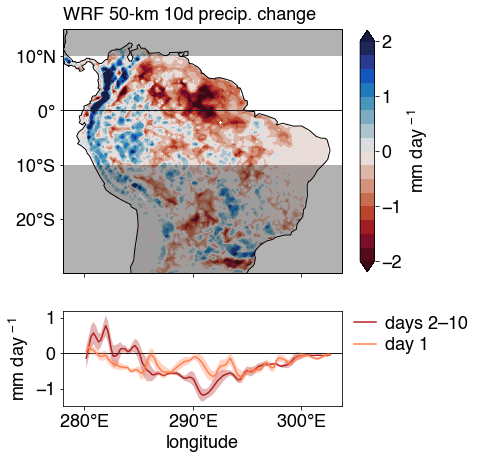

In [62]:
fontsize=18

fig = mp.figure(figsize=(5,6.5))
gs = matplotlib.gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[3, 1])

map_proj = cartopy.crs.PlateCarree()
levels1 = numpy.arange(-2,2.1,0.25)

ax1 = fig.add_subplot(gs[0], projection=map_proj)
contour1 = ax1.contourf(xlong[0,:], xlat[:,0], \
                        raintot_diffs_time_mean_landmask*24., \
                        levels=levels1, cmap=cmocean.cm.balance_r, extend='both')
ax1.set_extent([276,327.5,-30,15], crs=map_proj)
ax1.coastlines()
ax1.set_xticks([280-360.,300-360.,320-360.])
ax1.set_xticklabels(['','',''])
ax1.set_yticks([-20,-10,0,10])
ax1.set_yticklabels(['$20\degree$S','$10\degree$S', '$0\degree$', '$10\degree$N'])
ax1.tick_params(labelsize=fontsize)
ax1.axhline(0, c='0.1', lw=1)

ax1.fill_between(numpy.linspace(276,327.5,2), y1=-10, y2=-40, \
                 alpha=0.333, edgecolor='None', \
                 facecolor='0.1', transform=map_proj)
ax1.fill_between(numpy.linspace(276,327.5,2), y1=10, y2=40, \
                 alpha=0.333, edgecolor='None', \
                 facecolor='0.1', transform=map_proj)

ax1.text(s='WRF 50-km 10d precip. change', x=0, y=1.02, \
         transform=ax1.transAxes, \
         fontsize=fontsize, ha='left', va='bottom')

ax2 = fig.add_subplot(gs[1])
ax2.set_xlim(276,327.5)
ax2.tick_params(labelsize=fontsize)
ax2.set_xticks([280,300,320])
ax2.set_xticklabels(['$280\degree$E','$290\degree$E','$300\degree$E','$310\degree$E'])
ax2.set_xlabel('longitude', fontsize=fontsize)
ax2.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)
ax2.axhline(0, c='0.1', lw=1)

ax2.plot(xlong[0,xlong_indices]+360.,\
        raintot_diffs_latmean_days2to10[xlong_indices]*24., \
        c='firebrick', label='days 2–10')

ax2.fill_between(xlong[0,xlong_indices]+360., \
                (raintot_diffs_latmean_days2to10[xlong_indices]-raintot_diffs_latmean_std_days2to10[xlong_indices])*24.,\
                (raintot_diffs_latmean_days2to10[xlong_indices]+raintot_diffs_latmean_std_days2to10[xlong_indices])*24.,\
                facecolor='firebrick', alpha=0.333)

ax2.plot(xlong[0,xlong_indices]+360.,\
        raintot_diffs_latmean_day1[xlong_indices]*24., \
        c='coral', label='day 1', zorder=5)

ax2.fill_between(xlong[0,xlong_indices]+360., \
                (raintot_diffs_latmean_day1[xlong_indices]-raintot_diffs_latmean_std_day1[xlong_indices])*24.,\
                (raintot_diffs_latmean_day1[xlong_indices]+raintot_diffs_latmean_std_day1[xlong_indices])*24.,\
                facecolor='coral', alpha=0.333, zorder=5)

ax2.set_ylim(-1.4835328969152064, 1.1870771995510045)

fig.tight_layout()
h, l=ax2.get_legend_handles_labels()
ax2.legend(h, l, fontsize=fontsize, scatterpoints=1, bbox_to_anchor=(1.025,1.), \
            bbox_transform=ax2.transAxes, loc='upper left', borderaxespad=0, labelspacing=0.25, \
            fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
            handletextpad=0.5, markerscale=1, handlelength=1.25)

scale = .85
ax1pos = ax1.get_position()
cbar_ax = fig.add_axes([ax1pos.x1+0.05, ax1pos.y0+.5*(1-scale)*ax1pos.height, 0.04, ax1pos.height*scale])
cbar = mp.colorbar(contour1, cax=cbar_ax)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_ticks([-2,-1,0,1,2])

fig.savefig('figures/WRF_map_and_meridional_means_2lines.png', dpi=600, bbox_inches='tight', transparent=True)


# maps of change

In [95]:
cmap_custom = matplotlib.colors.ListedColormap([cmocean.cm.balance_r(0.1), \
                                                cmocean.cm.balance_r(0.25), \
                                                cmocean.cm.balance_r(0.4), \
                                                cmocean.cm.balance_r(0.55), \
                                                cmocean.cm.balance_r(0.6), \
                                                cmocean.cm.balance_r(0.65)])
                                                
cmap_custom.set_over(cmocean.cm.balance_r(.8))
cmap_custom.set_under(cmocean.cm.balance_r(0))

levels_2km = numpy.array([-10,-5,-0.5,0,0.5,5,10])
norm = matplotlib.colors.BoundaryNorm(levels_2km, cmap_custom.N)

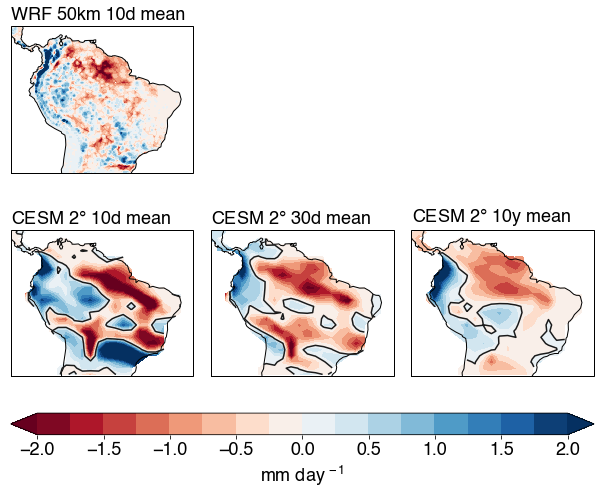

In [169]:
fontsize=18

fig = mp.figure(figsize=(8.5,6))

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(231, projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

# ax2 = fig.add_subplot(232, projection=map_proj)
# ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(234, projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(235, projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(236, projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-2,2.1,0.25)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], raintot_diffs_time_mean_landmask*24., levels=levels1, cmap='RdBu', extend='both')

# contour2 = ax2.contourf(xlong_2km[0,:], xlat_2km[:,0], raintot_diffs_2km_time_mean_landmask*24., \
#                         levels=levels_2km, cmap=cmap_custom, extend='both', norm=norm)

# #ax1.contour(xlong[0,:], xlat[:,0], raintot_diffs_2km_time_mean_landmask, levels=[0], colors='0.1')
# ax2.set_extent([273,329,-30,15], crs=map_proj)
# latmin_d03 = -2.243599
# latmax_d03 = 12.03965
# lonmin_d03 = 313.6654510498047
# lonmax_d03 = 277.7049255371094
# d03_width = lonmax_d03-lonmin_d03
# d03_height = latmax_d03-latmin_d03
# ax2.add_patch(matplotlib.patches.Rectangle(xy=[lonmin_d03, latmin_d03], width=d03_width, height=d03_height,
#                                 facecolor='none',
#                                 edgecolor='0.1',\
#                                 linewidth=2,\
#                                 transform=map_proj, zorder=2) )

contour3 = ax3.contourf(lon_subset, lat_subset, PRECT_diffs_10day*86400.*1000, levels=levels1, cmap='RdBu', extend='both')
ax3.contour(lon_subset, lat_subset, PRECT_diffs_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset, PRECT_diffs_30day*86400.*1000, levels=levels1, cmap='RdBu', extend='both')
ax4.contour(lon_subset, lat_subset, PRECT_diffs_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset, PRECT_diffs_10year*86400.*1000, levels=levels1, cmap='RdBu', extend='both')
ax5.contour(lon_subset, lat_subset, PRECT_diffs_10year, levels=[0], colors='0.1')

ax1.coastlines()
#ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

ax1.text(s='WRF 50km 10d mean', x=0, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='left', va='bottom')
#ax2.text(s='WRF 2km 10d mean', x=0, y=1.02, transform=ax2.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax3.text(s='CESM 2$\degree$ 10d mean', x=0, y=1.02, transform=ax3.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax4.text(s='CESM 2$\degree$ 30d mean', x=0, y=1.02, transform=ax4.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax5.text(s='CESM 2$\degree$ 10y mean', x=0, y=1.02, transform=ax5.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()#h_pad=2)

axlpos = ax3.get_position()
axrpos = ax5.get_position()

cbar_ax = fig.add_axes([axlpos.x0,axlpos.y0-0.065,axrpos.x1-axlpos.x0,0.05])
cbar = fig.colorbar(contour4, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)

# scale = 0.88
# axpos_2km = ax2.get_position()
# cbar_ax2 = fig.add_axes([axpos_2km.x1+0.03, axpos_2km.y0+.5*(1-scale)*axpos_2km.height, 0.025, axpos_2km.height*scale])
# cbar2 = fig.colorbar(contour2, cax=cbar_ax2, orientation='vertical')
# cbar_ax2.tick_params(labelsize=fontsize)
# cbar2.set_label('mm day$^{\,-1}$', fontsize=fontsize)


fig.savefig('figures/cesm_10day_30day_10year_mean_precip_change_WITH_WRF.png', dpi=600, bbox_inches='tight', transparent=True)
